# Compilers: Numba, Cython, pybind11

Speeding things up through parallel processing is called "horizontal scaling." Often, analysis code can also be accelerated on a single thread, known as "vertical scaling."

Horizontal and vertical scaling are complementary.

Let's illustrate this with the fractal example from last time.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import time

def run_numpy(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]  # ask Numpy to make an x, y grid for us
    c = x + y*1j                                         # c is a constant: a grid of complex coordinates
    z = c
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations   # the fractal image starts as "20" everywhere
    for i in range(maxiterations):
        z = z**2 + c                                     # iteratively apply z -> z**2 + c
        diverge = numpy.absolute(z) > 2                  # define "divergence" by |z| > 2
        divnow = diverge & (fractal == maxiterations)    # the pixels that are diverging in this iteration
        fractal[divnow] = i                              # the fractal image is a plot of the iteration number
        z[diverge] = 2                                   # clamp to 2 so they don't diverge too much
    return fractal

Stare at this code: it performs operations across the whole grid, identifies pixels that have diverged, and repeats everything 20 times, even though the parts that have already diverged are "done."

More significant than the unnecessary work, though, is the memory movement. Each `z**2 + c` creates new intermediate arrays, moving a lot of memory, flushing CPU caches. Nowadays, mathematical operations are much faster than memory movement.

As a reminder, this took 35 seconds to run.

In [3]:
starttime = time.time()
fractal = run_numpy(8000, 12000)
time.time() - starttime

35.37652039527893

If we weren't using Numpy, we'd write the algorithm differently: we'd deal with one pixel at a time. Once the pixel has diverged, we'd move on to the next, saving some work. But more importantly, we make only one pass over the image, avoiding repeated memory access.

In [5]:
def run_python(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations
    for h in range(height):
        for w in range(width):
            z = c[h, w]
            for i in range(maxiterations):
                z = z**2 + c[h, w]
                if abs(z) > 2:
                    fractal[h, w] = i
                    break
    return fractal

Before I run this, I'm going to drop the number of pixels from 8000×12000 to 800×1200, a factor of 100. We don't want to wait 900 seconds (15 minutes)!

In [6]:
starttime = time.time()
fractal = run_python(800, 1200)
time.time() - starttime

9.85081672668457

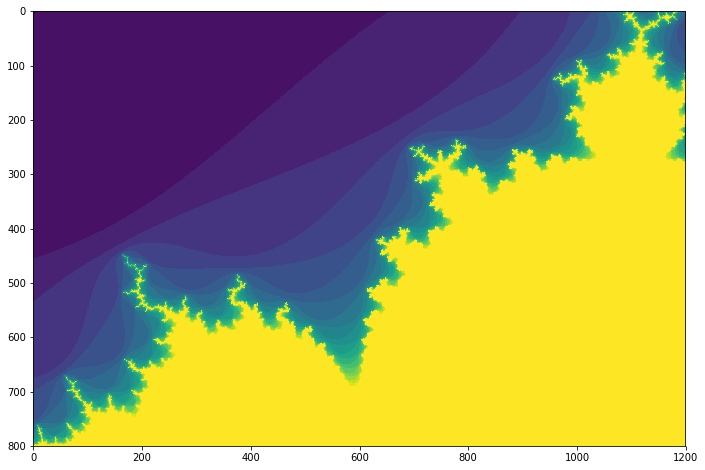

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(fractal)
# ax.imshow(fractal[-2000:, :3000])

It works, but it's _super slow!_ This is how an efficient algorithm would go, but stepping through each pixel in Python code kills performance due to all the type-checking, numeric boxing, and virtualization that Python does.

At this point, we'd normally start thinking about compiled code. And we should: compilation is exactly how to avoid all the aforementioned issues.

However, we _don't_ need to rewrite our code in another language.

In [8]:
import numba

@numba.jit
def run_numba_loop(height, width, maxiterations, c, fractal):
    for h in range(height):
        for w in range(width):
            z = c[h, w]
            for i in range(maxiterations):
                z = z**2 + c[h, w]
                if abs(z) > 2:
                    fractal[h, w] = i
                    break
    return fractal

def run_numba(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations
    return run_numba_loop(height, width, maxiterations, c, fractal)

In [10]:
starttime = time.time()
fractal = run_numba(8000, 12000, maxiterations=20)
time.time() - starttime

10.517540693283081

Numba is a "just in time" compiler (JIT) for numeric Python. That is, it compiles the Python code as soon as it knows the data types of the inputs, just before execution. (Remember that the compilation time is included in the measurement— it's small compared to 10 seconds, though.)

Numba knew to compile the `run_numba_loop` function because it was preceeded by the decorator `@numba.jit`. It is now a wrapped function.

In [11]:
run_numba_loop

CPUDispatcher(<function run_numba_loop at 0x7f4829b712f0>)

Its "overloads" are the saved, compiled functions for each signature. There's only one so far: `int, int, int, array(complex), array(int)`.

In [12]:
run_numba_loop.overloads

OrderedDict([((int64,
               int64,
               int64,
               array(complex128, 2d, C),
               array(int32, 2d, C)),
              CompileResult(typing_context=<numba.typing.context.Context object at 0x7f4829b4f400>, target_context=<numba.targets.cpu.CPUContext object at 0x7f4828307d30>, entry_point=<built-in method run_numba_loop of _dynfunc._Closure object at 0x7f48281181e8>, typing_error=None, type_annotation=<numba.annotations.type_annotations.TypeAnnotation object at 0x7f482923f3c8>, signature=(int64, int64, int64, array(complex128, 2d, C), array(int32, 2d, C)) -> array(int32, 2d, C), objectmode=False, lifted=(), fndesc=<function descriptor 'run_numba_loop$1'>, interpmode=False, library=<Library 'run_numba_loop' at 0x7f4829b38ac8>, call_helper=None, environment=<numba.lowering.Environment object at 0x7f4828236360>, has_dynamic_globals=False))])

Notice that we split the process into `run_numba`, a plain function, and `run_numba_loop`, a JIT-compiled function. Not all Python can be compiled, or we'd be doing it all the time! Python is a highly dynamic language (did you know you can change an object's class after it's created?), so there will always be things Python can do that a compiled language can't do. There will always be data types Numba doesn't recognize.

Numba lists the [Python language features](https://numba.pydata.org/numba-doc/latest/reference/pysupported.html) and [Numpy types and functions](https://numba.pydata.org/numba-doc/latest/reference/numpysupported.html) that it recognizes on its website. This is a growing list, bit it will never converge to the entirety of Python and all its libraries.

For the most part, Numba recognizes numbers and arrays, and even if it can handle a given language feature (iterators, classes), it will perform best on simple loops and straightforward code. Generally, you only want to wrap the most arithmetically intense part of your calculation.

In the above example, I didn't include the array-creation steps because the first one was an unsupported function (`numpy.ogrid`).

One of the early reasons for Numba's existence was to write new Numpy universal functions ("ufuncs").

In [92]:
@numba.vectorize
def as_ufunc(c, maxiterations):
    z = c
    for i in range(maxiterations):
        z = z**2 + c
        if abs(z) > 2:
            return i
    return maxiterations

def run_numba_2(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    return as_ufunc(c, maxiterations)

In [93]:
starttime = time.time()
fractal = run_numba_2(8000, 12000, maxiterations=20)
time.time() - starttime

10.519479036331177

In [15]:
type(as_ufunc)

numba.npyufunc.dufunc.DUFunc

This is only possible if the process we want to apply is elementwise— we do an independent thing to each element, and the output shape is the same as the input shape— because that's what a ufunc does. The function definition is much simpler since the input argument `c` is now a (complex) number, rather than an array. We don't need to write the for loops.

It even has the funky ufunc methods, like `.at` and `.reduce`:

In [16]:
a = numpy.arange(0, 2, 0.1) * 1j
a

array([0.+0.j , 0.+0.1j, 0.+0.2j, 0.+0.3j, 0.+0.4j, 0.+0.5j, 0.+0.6j,
       0.+0.7j, 0.+0.8j, 0.+0.9j, 0.+1.j , 0.+1.1j, 0.+1.2j, 0.+1.3j,
       0.+1.4j, 0.+1.5j, 0.+1.6j, 0.+1.7j, 0.+1.8j, 0.+1.9j])

In [17]:
as_ufunc.at(a, [0, 2, 4, 6, 8, 10, 12, 14], 20)
a

array([20.+0.j ,  0.+0.1j, 20.+0.j ,  0.+0.3j, 20.+0.j ,  0.+0.5j,
       20.+0.j ,  0.+0.7j, 16.+0.j ,  0.+0.9j, 20.+0.j ,  0.+1.1j,
        1.+0.j ,  0.+1.3j,  0.+0.j ,  0.+1.5j,  0.+1.6j,  0.+1.7j,
        0.+1.8j,  0.+1.9j])

Remember when I said horizontal and vertical scaling are complementary? I didn't say that they're multiplicative because it's sometimes much better than that. Let's put this Numba-compiled ufunc into Dask:

In [37]:
import dask.array

def run_dask(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = dask.array.from_array(x + y*1j, chunks=(100, 12000))
    return as_ufunc(c, maxiterations)

In [89]:
starttime = time.time()
fractal = run_dask(8000, 12000, maxiterations=20).compute()
time.time() - starttime

3.7252936363220215

It took

   * 35 seconds to run in Numpy on 1 core.
   * 21 seconds to run in Numpy on 12 cores with Dask.
   * 10 seconds to run as a Numba-compiled ufunc on 1 core.
   * 3.7 seconds to run as a Numba-compiled ufunc on 12 cores with Dask.

Dask multiprocessing scales better with the Numba-compiled ufunc because it's a much simpler computation graph. Dask can't see inside `as_ufunc` to worry about interdependencies.

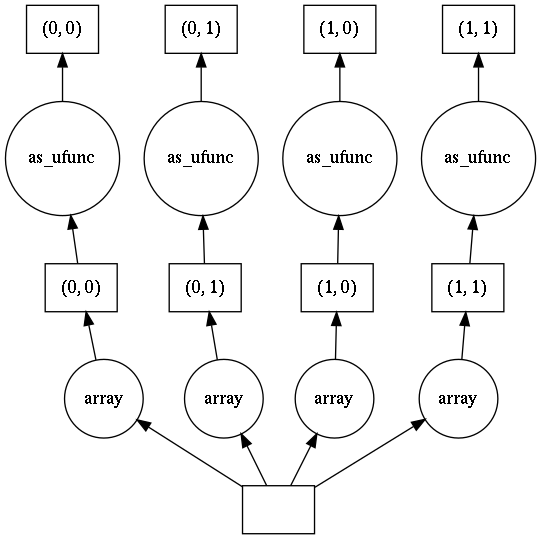

In [49]:
c = dask.array.from_array(numpy.array([[0j, 1j], [0j, 1j]]), chunks=(1, 1))
as_ufunc(c, 20).visualize()

Remember how it used to look? How its complexity scaled with the number of iterations? Now all of that is internal to `as_ufunc`.

(Incidentally, the reason it's not scaling beyond 3 cores is likely memory bandwidth: the above example was fetching memory at 1.5 GB/sec, which I've found to be an approximate limit on all systems I've encountered except for Knight's Landing's MCDRAM.)

I presented Numba first because it involves the least change to your code— the orthodox mantra is to get your code working first, profile it to find the slowest parts, and only accelerate those parts. Numba lets you do that with the least effort.

But sometimes you need something more: features that are only available in C++, for instance. Python is unable to express some concepts related to performance tuning (deliberately: to keep the language simple) and compilers aren't magical— Numba can't always guess what you mean.

Cython is a halfway language, part Python and part C/C++. It translates to C or C++ and uses a conventional compiler to turn into a Python extension module. They also have a Jupyter extension, which I'll use for this demo.

In [51]:
%load_ext Cython

The following cell creates C++ code from Python, compiles it, and loads the resulting Python module.

In [55]:
%%cython --cplus
import numpy

def run_cython(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations
    for h in range(height):
        for w in range(width):
            z = c[h, w]
            for i in range(maxiterations):
                z = z**2 + c[h, w]
                if abs(z) > 2:
                    fractal[h, w] = i
                    break
    return fractal

In [56]:
starttime = time.time()
fractal = run_cython(800, 1200)
time.time() - starttime

7.00913667678833

But the resulting _compiled_ module runs almost as slowly as Python itself: 7 sec vs 9.5 sec (note: we're using the smaller grid again, so this is hundreds of times slower than Numpy or Numba). Why is that? Isn't this compiled?

The issue is that Cython does nothing about all the runtime type-checking of Python objects. Numba replaced Python objects with raw numbers, where possible, which makes the real difference.

Cython chose to cover the entire Python language and make naive translations by default. Numba chose to make optimized translations by default but not cover the entire Python language.

To get optimizations, we have to introduce C++ by hand.

In [96]:
%%cython --cplus --annotate
import cython
import numpy      # load Python interface to Numpy
cimport numpy     # load C++ interface to Numpy (types end in _t)

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping (e.g. -1 for last element)
def run_cython(int height, int width, int maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations

    cdef numpy.ndarray[numpy.complex128_t, ndim=2, mode="c"] c_array = c
    cdef numpy.ndarray[numpy.int32_t,      ndim=2, mode="c"] fractal_array = fractal
    cdef numpy.complex128_t z
    
    for h in range(height):
        for w in range(width):
            z = c_array[h, w]
            for i in range(maxiterations):
                z = z**2 + c_array[h, w]
                if abs(z) > 2:
                    fractal_array[h, w] = i
                    break
    return fractal

(Still using the small grid; still unable to scale to native speeds.)

In [97]:
starttime = time.time()
fractal = run_cython(800, 1200)
time.time() - starttime

1.4422461986541748

In addition to importing Python libraries, Cython can include C++ headers. A hidden feature in the `cdef extern` syntax for including C++ allows you to write literal C++ in your Cython.

In [135]:
%%cython --cplus -c-O3
import numpy

cdef extern from *:
    """
    #include <complex>
    void quick(int height, int width, int maxiterations, double* c, int* fractal) {
        for (int h = 0;  h < height;  h++) {
            for (int w = 0;  w < width;  w++) {
                double creal = c[2 * (h + height*w)];
                double cimag = c[2 * (h + height*w) + 1];
                std::complex<double> ci = std::complex<double>(creal, cimag);
                std::complex<double> z = ci;
                for (int i = 0;  i < maxiterations;  i++) {
                    z = z * z + ci;
                    if (std::abs(z) > 2) {
                        fractal[h + height*w] = i;
                        break;
                    }
                }
            }
        }
    }
    """
    void quick(int height, int width, int maxiterations, double* c, int* fractal)

def run_cython(int height, int width, int maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations
    quick(height, width, maxiterations, <double*>(<size_t>c.ctypes.data), <int*>(<size_t>fractal.ctypes.data))
    return fractal

(Now we can use the large grid. This is only 2× slower than Numba.)

In [136]:
starttime = time.time()
fractal = run_cython(8000, 12000)
time.time() - starttime

18.961424112319946

Although Cython was originally intended as a code optimizer (you can see that it's difficult to use it that way!), it has come to be used to _bind_ C++ libraries as Python extensions, since it can speak both languages.

Today, there's another alternative: pybind11 is a C++ header for binding to Python (coming from the other direction, from C++ to Python).

I would recommend:

   * Numba for accelerating small bits of numerical code.
   * Cython for mixing C++ into a mostly Python script: for instance, to access C++ only libraries.
   * pybind11 for wrapping C++ cleanly as Python modules: for instance, you're distributing a C++ library for use in Python.

(I've dropped pybind11 content in the interests of time.)